In [1]:
%load_ext autoreload
%autoreload 2

# Classifying Music Note sounds using Few Shot Deep Learning

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import math

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

#### utils

In [4]:
def fft(f):
    Ni = len(f)
    Mi = int(Ni / 2)
    if Mi <= 2:
        return [f[0] + f[1] + f[2] + f[3], 
               f[0] - 1j*f[1] - f[2] + 1j*f[3],
               f[0] - f[1] + f[2] - f[3],
               f[0] + 1j*f[1] - f[2] - 1j*f[3]]
    
    wn = math.cos(2*math.pi/Ni) - 1j*math.sin(2*math.pi/Ni)
    fe = [f[i] for i in range(Ni) if i % 2 == 0]
    fo = [f[i] for i in range(Ni) if i % 2 == 1]
    Fe = fft(fe)
    Fo = fft(fo)
    return [np.around(Fe[i] + (wn**i)*Fo[i], decimals=10) for i in range(Mi)] + [np.around(Fe[i] - (wn**i)*Fo[i], decimals=10) for i in range(Mi)]

def get_audio_data(filename):
    fs = 2**12 # sample rate
    tp = 2 # sampling duration
    N = n = fs*tp # number of samples
    
    # Extract data and sampling rate from file
    recording, fs = librosa.load(filename, sr=fs, duration=tp, mono=True)

    n = len(recording)        
    tp = int(n / fs)

    if tp < 2:
        pad_width = N - recording.shape[0]
        recording = np.pad(recording, pad_width=((0, pad_width),), mode='constant')

        n = len(recording)
        tp = int(n / fs)

    N = fs*tp # number of samples
    x = [np.round(float(recording[i]), 10) for i in range(n)] # input sequence
    return x, tp, n

def get_frequency_amplitude(x, tp, N):
    _X = fft(x) # discrete Fourier transform
    X = [np.round(Xi/N, 10) for Xi in _X] # frequency spectrum
    X_amp = [np.absolute(Xi) for Xi in X] # amplitude spectrum

    M = int(N/2)
    ti = [i*tp/N for i in range(N)]
    fi = [i/tp for i in range(M)]
    X_amp = np.array(X_amp[:M])*2
    
    return ti, fi, X_amp

def extract_features(filepath):
    # try:
    audio_features = get_audio_data(filepath)
    if not audio_features:
        return

    x, tp, N = audio_features
    ti, fi, X_amp = get_frequency_amplitude(x, tp, N)
    return X_amp
#     return fi, X_amp
    
    # except Exception as e:
    #     print("Error encountered while parsing file: ", file_name, e)
    #     return None 
    
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=3) 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    pad_width = 256 - mfccs.shape[1]
    
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')     
    return mfccs
    

#### Load Preprocessed data 

In [5]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
DATA_DIR = os.path.join("data", "guitar_sample")
# DATA_DIR = os.path.join("/content/drive/My Drive/Colab Notebooks/data", "guitar_sample")

# feature list
features = []
labels = os.listdir(DATA_DIR)

# Iterate through each sound file and extract the features 
for folder in tqdm(labels):
    class_label = folder
    if class_label.startswith("0"):
        continue
        
    for file in os.listdir(os.path.join(DATA_DIR, folder)):
        file_name = os.path.join(os.path.join(DATA_DIR, folder, file))
        
        data = extract_features(file_name)
        if data is None:
            continue
        
        data = np.array(data)
        data = np.expand_dims(data, axis=-1)
        features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
labels = np.unique(featuresdf.class_label)

print('Finished feature extraction from ', len(featuresdf), ' files') 


Finished feature extraction from  118  files


In [6]:
# featuresdf.feature = featuresdf.feature.apply(lambda xx: xx.reshape((4096, 2)))
featuresdf.feature.iloc[0].shape

(40, 256, 1)

In [7]:
featuresdf.head()

,feature,class_label
0,"[[[-403.97342], [-427.74152], [-478.33362], [-...",1A
1,"[[[-449.60074], [-470.32797], [-528.5974], [-5...",1A
2,"[[[-374.77917], [-398.41254], [-462.8929], [-4...",1A
3,"[[[-400.76926], [-423.18558], [-481.08386], [-...",1A
4,"[[[-391.5319], [-416.02634], [-477.748], [-511...",1A


In [8]:
from itertools import combinations
from math import factorial

def number_of_combinations(n, r):
    return int(factorial(n) / (factorial(n - r) * factorial(r)))

def prepare_data_pair(X, y, labels):
    data = [[], [], []]
    data_labels = [[], [], []]
    
    for label in labels:
        label = f"1{label}"
        semilabel = f"0{label}"

        indices = np.array(list(range(len(y))))
        similar_indices = indices[y == label]
        
        if len(similar_indices) < 2:
            continue
        
        train_half_size = number_of_combinations(len(similar_indices), 2)
        semisimilar_indices = indices[y == semilabel][:train_half_size]

        dissimilar_indices = indices[(y != label) & (y != semilabel)]
        np.random.shuffle(dissimilar_indices)

        dissimilar_indices = dissimilar_indices[:train_half_size - len(semisimilar_indices)]
        dissimilar_indices = np.concatenate([semisimilar_indices, dissimilar_indices])

        np.random.shuffle(dissimilar_indices)
        it = iter(dissimilar_indices)
        
        counter = 0
        for i, j in combinations(similar_indices, 2):
            if counter >= len(dissimilar_indices):
                break
                
            counter += 1
            z = next(it)
            
            for index, value in enumerate([i, j, z]):
                data[index].append(X[value])
                data_labels[index].append(y[value])
            
        print(y[i], y[j], y[z])
    
    data = np.array(data)
    data_labels = np.array(data_labels)
    return data, data_labels

In [9]:
labels

array(['1A', '1B', '1D', '1EH', '1EL', '1G'], dtype=object)

In [10]:
# split the dataset 
from sklearn.model_selection import train_test_split 

# Convert features and corresponding classification labels into numpy arrays
input_data = np.array(featuresdf.feature.tolist())
output_labels = np.array(featuresdf.class_label.tolist())

from sklearn.model_selection import StratifiedShuffleSplit

# split train and test data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=100)
for train_index, test_index in sss.split(input_data, output_label):
    x_train, x_test = input_data[train_index], input_data[test_index]
    y_train_label, y_test_label = output_label[train_index], output_label[test_index]
    
# labels
labels = ["EH", "D", "A", "B", "G", "EL"]

# prepare data set pairs
x_train_pair, y_train_pair = prepare_data_pair(x_train, y_train, labels)

1EH 1EH 1G
1D 1D 1EH
1A 1A 1EH
1B 1B 1G
1G 1G 1A
1EL 1EL 1G


In [11]:
x_train.shape, y_train.shape

((94, 40, 256, 1), (94,))

In [12]:
x_test.shape, y_test.shape

((24, 40, 256, 1), (24,))

In [13]:
x_train_pair.shape, y_train_pair.shape

((3, 470, 40, 256, 1), (3, 470))

In [14]:
for i in range(3):
    print(y_train_pair[:, i])

['1EH' '1EH' '1EL']
['1EH' '1EH' '1G']
['1EH' '1EH' '1A']


### Convolutional Neural Network (CNN) model architecture 

In [50]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Lambda, LayerNormalization, Layer
from tensorflow.keras.layers import BatchNormalization as LayerNormalization, GlobalAveragePooling2D
# from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Conv2D as Conv1D, MaxPooling2D as MaxPooling1D
K.clear_session()

def build_base_network(input_shape):
    model = Sequential()
    
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
#     model.add(LayerNormalization(axis=2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))
    
    model.add(Conv1D(16, kernel_size=3, activation='relu'))
#     model.add(LayerNormalization(axis=2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))
    
    model.add(Conv1D(8, kernel_size=3, activation='relu'))
#     model.add(LayerNormalization(axis=2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))
    
#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
# #     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))
    
#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))
    
#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))

#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))

#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))
    
#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))
    
    model.add(Flatten())
    
#     model.add(Dense(1024))
#     model.add(LayerNormalization(axis=-1))
#     model.add(Dropout(0.25))
    
    model.add(Dense(512))
    model.add(LayerNormalization(axis=-1))
    model.add(Dropout(0.15))
    
    model.add(Dense(256))
#     model.add(LayerNormalization(axis=1))
    model.add(Dropout(0.05))
    
    model.add(Dense(128))
    return model

def build_base_network2(input_dim):
    # We only test DenseNet-121 in this script for demo purpose
    
    base_model = tf.keras.applications.DenseNet201(
    # base_network = tf.keras.applications.InceptionV3(
    # base_network = tf.keras.applications.ResNet101(
        include_top=False, weights=None, input_tensor=None, input_shape=input_dim,
        pooling="max", classes=128
    )
    
    # add a global spatial average pooling layer
    x = base_model.output
    
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(128)(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    return model
    
def distance(emb1, emb2):
    return K.sum(K.square(emb1 - emb2), axis=-1)

### Compiling the model 

For compiling our model, we will use the same three parameters as the previous model: 

In [81]:
# from model import create_model as build_base_network

input_dim = x_train_pair.shape[2:]
base_network = build_base_network(input_dim)

audio_a = Input(shape=input_dim)
audio_p = Input(shape=input_dim)
audio_n = Input(shape=input_dim)

feat_vecs_a = base_network(audio_a)
feat_vecs_p = base_network(audio_p)
feat_vecs_n = base_network(audio_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
    def get_config(self):
        config = super(TripletLossLayer, self).get_config()
        config.update({"alpha": self.alpha})
        return config

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
difference = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([feat_vecs_a, feat_vecs_p, feat_vecs_n])

# initialize the network
model = Model(inputs=[audio_a, audio_p, audio_n], outputs=difference)

In [82]:
input_dim

(40, 256, 1)

In [83]:
# Display model architecture summary 
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 40, 256, 1)] 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 40, 256, 1)] 0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 40, 256, 1)] 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          541528      input_7[0][0]                    
                                                                 input_8[0][0]         

In [84]:
model.layers[3].summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 38, 254, 32)       320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 19, 127, 32)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 19, 127, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 17, 125, 16)       4624      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 62, 16)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 8, 62, 16)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 60, 8)         

### Training 

Here we will train the model. As training a CNN can take a sigificant amount of time, we will start with a low number of epochs and a low batch size. If we can see from the output that the model is converging, we will increase both numbers.  

In [85]:
from tensorflow.keras.callbacks import ModelCheckpoint 
from time import time

checkpointer = ModelCheckpoint(
    filepath='saved_models/weights.best.basic_cnn.hdf5', 
    verbose=1, 
    save_best_only=True
)

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# initialize training params
epochs = 16
batch_size = 32

# optimizer = Adam()
optimizer = RMSprop()
model.compile(loss=None, optimizer=optimizer)

start = time()
model.fit(
    [x_train_pair[0], x_train_pair[1], x_train_pair[2]], 
    None, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=0.25,
    callbacks=[early_stopper, checkpointer], 
    verbose=1
)

duration = (time() - start)/60
print("Training completed in time: ", duration, "min")

Epoch 1/16
11/11 [==============================] - ETA: 0s - loss: 484.3480
Epoch 00001: val_loss improved from inf to 103.95722, saving model to saved_models\weights.best.basic_cnn.hdf5
11/11 [==============================] - 9s 796ms/step - loss: 484.3480 - val_loss: 103.9572
Epoch 2/16
11/11 [==============================] - ETA: 0s - loss: 167.0072
Epoch 00002: val_loss improved from 103.95722 to 93.91332, saving model to saved_models\weights.best.basic_cnn.hdf5
11/11 [==============================] - 8s 737ms/step - loss: 167.0072 - val_loss: 93.9133
Epoch 3/16
11/11 [==============================] - ETA: 0s - loss: 105.8282
Epoch 00003: val_loss improved from 93.91332 to 35.07957, saving model to saved_models\weights.best.basic_cnn.hdf5
11/11 [==============================] - 8s 721ms/step - loss: 105.8282 - val_loss: 35.0796
Epoch 4/16
11/11 [==============================] - ETA: 0s - loss: 17.2586
Epoch 00004: val_loss improved from 35.07957 to 12.67769, saving model to 

In [86]:
# load weights
model.load_weights("saved_models/weights.best.basic_cnn.hdf5")

#### Evaluation

### Best freq treshold

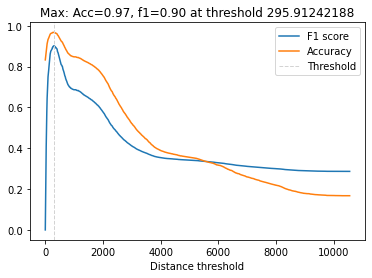

In [87]:
from sklearn.metrics import f1_score, accuracy_score

def get_eval_params(data_input, data_labels):
    pairs = []
    distances = [] # squared L2 distance between pairs
    identical = [] # 1 if same identity, 0 otherwise

    num = len(data_input)
    embedded = model.layers[3].predict(data_input)

    for i in range(num):
        for j in range(num):
            pairs.append([embedded[i], embedded[j]])
            distances.append(distance(embedded[i], embedded[j]))
            identical.append(1 if data_labels[i] == data_labels[j] else 0)
            
    pairs = np.array(pairs)
    distances = np.array(distances)
    identical = np.array(identical)
    
    return pairs, distances, identical, embedded

train_pairs, train_distances, train_identical, train_embedded = get_eval_params(x_train, y_train)
test_pairs, test_distances, test_identical, test_embedded = get_eval_params(x_test, y_test)

min_threshold = min(train_distances)
max_threshold = max(train_distances)
threshold_step = (max_threshold - min_threshold)/1000
thresholds = np.arange(min_threshold, max_threshold, threshold_step)

f1_scores = [f1_score(train_identical, train_distances < t) for t in thresholds]
acc_scores = [accuracy_score(train_identical, train_distances < t) for t in thresholds]

# max f1
opt_idx = np.argmax(f1_scores)
opt_f1 = np.max(f1_scores)

# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]

# Accuracy at maximal F1 score
opt_acc = accuracy_score(train_identical, train_distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Max: Acc={opt_acc:.2f}, f1={opt_f1:.2f} at threshold {opt_tau:.8f}');
plt.xlabel('Distance threshold')
plt.legend();

In [88]:
train_distances.shape, train_pairs.shape, train_identical.shape

((8836,), (8836, 2, 128), (8836,))

In [89]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

prediction = test_distances < opt_tau

print("accuracy =", accuracy_score(test_identical, prediction))

print("\nclassification_report")
print("========================")
print(classification_report(test_identical, prediction))

print("\nconfusion matrix")
print("========================")
print(confusion_matrix(test_identical, prediction))

accuracy = 0.9444444444444444

classification_report
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       468
           1       0.79      0.96      0.87       108

    accuracy                           0.94       576
   macro avg       0.89      0.95      0.92       576
weighted avg       0.95      0.94      0.95       576


confusion matrix
[[440  28]
 [  4 104]]


### Testing Evaluation

In [90]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

le.classes_

array(['1A', '1B', '1D', '1EH', '1EL', '1G'], dtype='<U3')

In [91]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

using_distance = True

clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto'))
# clf = make_pipeline(StandardScaler(), LogisticRegression(multi_class="ovr", random_state=0, max_iter=128))

if using_distance:
    xx_train, yy_train = train_distances.reshape(-1, 1), train_identical
    xx_test, yy_test = test_distances.reshape(-1, 1), test_identical

else:
    xx_train, yy_train = train_embedded, y_train_le
    xx_test, yy_test = test_embedded, y_test_le

clf.fit(xx_train, yy_train)
print(f"training accuracy = {clf.score(xx_train, yy_train):.2f}")

training accuracy = 0.97


In [92]:
xx_train.shape, yy_train.shape

((8836, 1), (8836,))

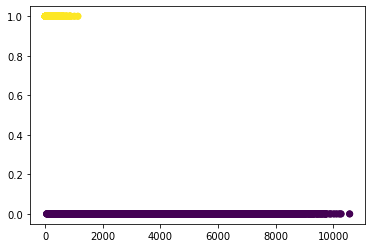

In [93]:
if using_distance:
    plt.scatter(xx_train, yy_train, c=yy_train)

In [94]:
print(f"test accuracy = {clf.score(xx_test, yy_test):.2f}")

test accuracy = 0.94


In [95]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(xx_test)
confusion_matrix(yy_test, y_pred)

array([[436,  32],
       [  4, 104]], dtype=int64)

In [96]:
np.unique(yy_test), np.unique(y_pred)

(array([0, 1]), array([0, 1]))

In [97]:
from sklearn.metrics import classification_report

print(classification_report(yy_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       468
           1       0.76      0.96      0.85       108

    accuracy                           0.94       576
   macro avg       0.88      0.95      0.91       576
weighted avg       0.95      0.94      0.94       576



### Testing (new data) Evaluation

In [98]:
x_test_sample = []
y_test_sample = []

sample_dirs = ["EH", "D", "A", "B", "G", "EL"]
# sample_dirs = ["A"]

for label in tqdm(sample_dirs):
    print(label, end=", ")
    labeldir= os.path.join("data", "old_guitar_sample", label)

    for filename in (os.listdir(labeldir)):
        anchor_filepath = os.path.join("data", "old_guitar_sample", label, filename)
        
        anchor_file_vector = extract_features(anchor_filepath)
        anchor_file_vector = np.expand_dims(anchor_file_vector, axis=-1)
        x_test_sample.append(anchor_file_vector)
        y_test_sample.append("1"+label)

print()
x_test_sample = np.array(x_test_sample)
y_test_sample = np.array(y_test_sample)

print(x_test_sample.shape)

EH, D, A, B, G, EL, 

(58, 40, 256, 1)


In [99]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise
prediction = []

num = len(x_test_sample)
print(x_test_sample.shape)
embedded = model.layers[3].predict(x_test_sample)

for i in range(num):
    for j in range(num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if y_test_sample[i] == y_test_sample[j] else 0)
        prediction.append(1 if distances[-1] < opt_tau else 0)
        
distances = np.array(distances)
identical = np.array(identical)
prediction = np.array(prediction)

print("accuracy =", accuracy_score(identical, prediction))

print("\nclassification_report")
print("========================")
print(classification_report(identical, prediction))

print("\nconfusion matrix")
print("========================")
print(confusion_matrix(identical, prediction))

(58, 40, 256, 1)
accuracy = 0.8632580261593341

classification_report
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      2802
           1       0.55      0.94      0.70       562

    accuracy                           0.86      3364
   macro avg       0.77      0.89      0.80      3364
weighted avg       0.91      0.86      0.88      3364


confusion matrix
[[2378  424]
 [  36  526]]


In [100]:
if using_distance:
    x_test_sample, y_test_sample = distances.reshape(-1, 1), identical

else:
    x_test_sample, y_test_sample = embedded, le.transform(y_test_sample)

In [101]:
print(f"test accuracy = {clf.score(x_test_sample, y_test_sample):.2f}")

test accuracy = 0.86


In [102]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(x_test_sample)
confusion_matrix(y_test_sample, y_pred)

array([[2360,  442],
       [  36,  526]], dtype=int64)

In [103]:
from sklearn.metrics import classification_report

print(classification_report(y_test_sample, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      2802
           1       0.54      0.94      0.69       562

    accuracy                           0.86      3364
   macro avg       0.76      0.89      0.80      3364
weighted avg       0.91      0.86      0.87      3364



### Testing (sample) Evaluation

In [104]:
x_test_sample = []
y_test_sample = []

sample_dirs = ["1EH", "1D", "1A", "1B", "1G", "1EL"]

sample_label = "1A"
sample_filepath = os.path.join("data", "sampleA.wav")
sample_vector = extract_features(sample_filepath)
sample_vector = np.expand_dims(np.expand_dims(sample_vector, axis=-1), axis=0)
sample_embedded = model.layers[3].predict(sample_vector)

for label in tqdm(sample_dirs):
    print(label, end=", ")
    labeldir= os.path.join(DATA_DIR, label)

    for filename in (os.listdir(labeldir)):
        anchor_filepath = os.path.join(DATA_DIR, label, filename)
        
        anchor_file_vector = extract_features(anchor_filepath)
        anchor_file_vector = np.expand_dims(anchor_file_vector, axis=-1)
        x_test_sample.append(anchor_file_vector)
        y_test_sample.append(label)

print()
x_test_sample = np.array(x_test_sample)
y_test_sample = np.array(y_test_sample)

print(x_test_sample.shape)

1EH, 1D, 1A, 1B, 1G, 1EL, 

(118, 40, 256, 1)


In [105]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

identical = []
distances = [] # squared L2 distance between pairs
prediction = []

num = len(x_test_sample)
embedded = model.layers[3].predict(x_test_sample)

for i in range(num):
    identical.append(1 if sample_label == y_test_sample[i] else 0)
    distances.append(distance(embedded[i], sample_embedded))
    prediction.append(1 if distances[-1] < opt_tau else 0)

identical = np.array(identical)
distances = np.array(distances)
prediction = np.array(prediction)

print("accuracy =", accuracy_score(identical, prediction))

print("\nclassification_report")
print("========================")
print(classification_report(identical, prediction))

print("\nconfusion matrix")
print("========================")
print(confusion_matrix(identical, prediction))

accuracy = 0.711864406779661

classification_report
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        98
           1       0.00      0.00      0.00        20

    accuracy                           0.71       118
   macro avg       0.40      0.43      0.42       118
weighted avg       0.67      0.71      0.69       118


confusion matrix
[[84 14]
 [20  0]]


In [106]:
if using_distance:
    x_test_sample, y_test_sample = distances.reshape(-1, 1), identical

else:
    x_test_sample, y_test_sample = sample_embedded, le.transform([sample_label])

In [107]:
print(f"test accuracy = {clf.score(x_test_sample, y_test_sample):.2f}")

test accuracy = 0.70


In [108]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(x_test_sample)
confusion_matrix(y_test_sample, y_pred)

array([[83, 15],
       [20,  0]], dtype=int64)

In [109]:
from sklearn.metrics import classification_report

print(classification_report(y_test_sample, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        98
           1       0.00      0.00      0.00        20

    accuracy                           0.70       118
   macro avg       0.40      0.42      0.41       118
weighted avg       0.67      0.70      0.69       118

